In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
import sys
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

# Ensure project root on sys.path for local imports when running directly
try:
    HERE = os.path.dirname(os.path.abspath(__file__))  # type: ignore[name-defined]
except NameError:
    HERE = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(HERE, ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from cls import WMEnv
from cls.utils.GridUtils import VectorHash
from cls.envs.environments import GridWMEnv
from cls.vectorhash.seq_utils import *
from cls.vectorhash.assoc_utils_np import *
from cls.vectorhash.senstranspose_utils import *
from  cls.vectorhash.assoc_utils_np_2D import gen_gbook_2d, path_integration_Wgg_2d, module_wise_NN_2d

seed = 3
rng = np.random.default_rng(seed)

In [118]:
def khot_to_gaussian_np(x: np.ndarray, sigma: float, wrap: bool = True,
                        normalize: str = "none") -> np.ndarray:
    """
    Same API as the torch version, but for NumPy arrays.
    """
    x = x.astype(float, copy=False)
    N = x.size
    if N == 0 or sigma <= 0:
        return np.zeros_like(x, dtype=float)

    idxs = np.flatnonzero(x != 0)
    if idxs.size == 0:
        return np.zeros_like(x, dtype=float)

    positions = np.arange(N)[None, :]            # [1, N]
    centers   = idxs[:, None]                    # [K, 1]
    d = positions - centers                      # [K, N]

    if wrap:
        d = np.abs(d)
        d = np.minimum(d, N - d)

    g = np.exp(-0.5 * (d / sigma) ** 2)          # [K, N]
    y = (g * x[idxs][:, None]).sum(axis=0)       # [N]

    if normalize == "max":
        m = y.max()
        if m > 0:
            y = y / m
    elif normalize == "sum":
        s = y.sum()
        if s > 0:
            y = y / s

    return y

def smooth_g(g, lambdas, FWHM_ratio):
    gin = g.copy()
    gout = np.zeros_like(gin)
    i = 0
    for l in lambdas:
        #want FWHM to be a quarter of the lambda
        fwhm = l * FWHM_ratio
        sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
        gout[i:i+l] = khot_to_gaussian_np(gin[i:i+l], sigma)
        i += l
    return gout

def overlaps(self, x, y, px, py, size, touch_ok=True):
        if touch_ok:
            # touching edges allowed
            return not (x + size <= px or px + size <= x or y + size <= py or py + size <= y)
        else:
            # touching counts as overlap
            return not (x + size <  px or px + size <  x or y + size <  py or py + size <  y)

## HPC

In [ ]:
# Initialize a pool of environments with fixed goals per env
# NOT USEFUL RIGHT NOW, DON'T NEED SCAFFOLD AT ALL
seed = 1
size = 5
speed = 1
n_envs = 2
rng = np.random.RandomState(seed)
env_pool = []
Np = 3600
lambdas = [5,6,7]
input_type = "g"
observation_size = 512
start_type = "wall"

print("Setting up VectorHash")
vectorhash = VectorHash(Np=Np, lambdas=lambdas, size=size)

print("Setting up Envs")
for i in range(n_envs):
    env_i = GridWMEnv(size=size, speed=speed, seed=int(rng.randint(0, 10_000_000)), observation_size=observation_size, input_type=input_type, start_type="wall")
    env_pool.append(env_i)

vectorhash.initiate_vectorhash(env_pool)
env = env_pool[0]
gbook = vectorhash.gbook
path_sbook = vectorhash.path_sbook
path_gbook = vectorhash.path_gbook
pbook = vectorhash.pbook
path_pbook = vectorhash.path_pbook
env_locations = vectorhash.env_locations #corner locations for each environment
Wpg = vectorhash.Wpg
thresh = vectorhash.thresh

print(vectorhash.grid_onehot_to_indices(gbook[:, 0, 0])) # indices of each phase
print(vectorhash.get_loc_from_grid_state(gbook[:, 0, 0])) # location in enivronment
print(env_locations)

Setting up VectorHash
Setting up Envs
   setup scaffold
      gen_gbook_2d
(3600, 110)
(110, 210, 210)
      pbook
(3600, 210, 210)
      train_gcpc
(110, 3600)
   setup envs
   initialize envs vh
[0 0 0 0 0 0]
(0, 0)


In [ ]:
all_env_indices = []
goal_states = []
for env_idx in range(n_envs):
    C_X, C_Y = env_locations[env_idx]
    x, y = np.meshgrid(np.arange(size), np.arange(size), indexing='ij')
    env_indices = np.stack((C_X + x, C_Y + y), axis=-1)
    all_env_indices.append(env_indices)

    flat_env = env_indices.reshape(-1, 2)
    goal_loc = flat_env[np.random.choice(len(flat_env))]
    goal_states.append(pbook[:, goal_loc[0], goal_loc[1]])


## 1D Grid

In [113]:
lambdas = np.arange(11, 30, 7)
Ng = np.sum(lambdas)
Npos = np.prod(lambdas)
gbook = gen_gbook(lambdas, Ng, Npos)

In [115]:
lambdas

array([11, 18, 25])

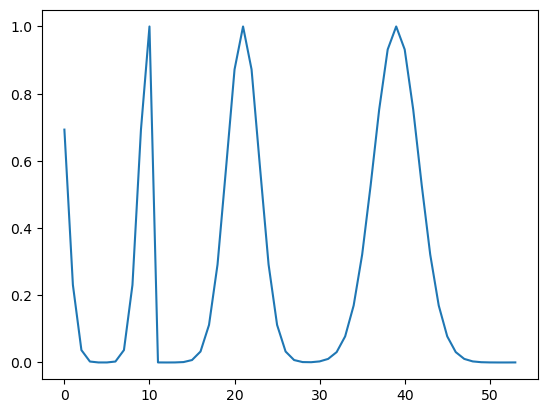

In [116]:
plt.plot(smooth_g(gbook[:, 10], lambdas, 0.25))
plt.show()

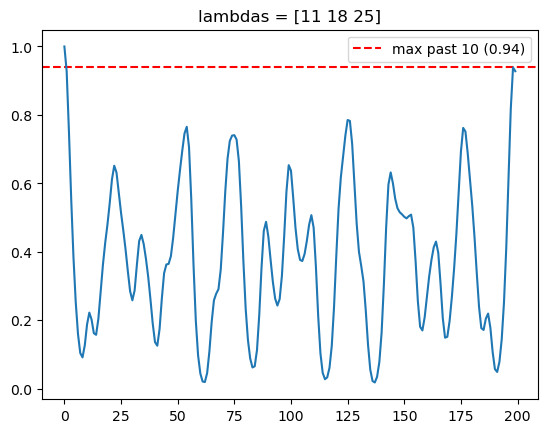

In [117]:
for sigma in [0.25]:
    phix = smooth_g(gbook[:, 0], lambdas, sigma)
    sims = []
    for i in range(200): #gbook.shape[1]):
        phi_deltax = smooth_g(gbook[:, i], lambdas, sigma)
        sim = np.sum(phix * phi_deltax) / np.sqrt(np.sum(phix**2) * np.sum(phi_deltax**2))
        sims.append(sim)
    # Find the index and value of the max point past the first 10 points
    max_idx = 10 + np.argmax(sims[10:])
    max_val = sims[max_idx]
    plt.axhline(y=max_val, color='r', linestyle='--', label=f'max past 10 ({max_val:.2f})')
    # plt.axvline(x=1, color='g', linestyle='--', label='x = 1')
    plt.plot(sims)
    plt.title(f"lambdas = {lambdas}")
    plt.legend()
    plt.show()

## 2D Grid

In [ ]:
lambdas = [17,19]
Ng = np.sum(np.square(lambdas))
Npos = np.prod(lambdas)
gbook = gen_gbook_2d(lambdas, Ng, Npos)
n_envs = 2

In [ ]:
used = []  # store placed (x, y)
C_pairs = []
max_tries = 10_000  # guard against infinite loops
touch_ok = False      # set False to forbid touching
tries = 0
while len(C_pairs) < n_envs and tries < max_tries:
    x = np.random.randint(0, Npos - size + 1)
    y = np.random.randint(0, Npos - size + 1)
    if all(not overlaps(x, y, px, py, size, touch_ok) for (px, py) in used):
        used.append((x, y))
        C_pairs.append((x, y))
    tries += 1

In [43]:
C_pairs

[(276, 237), (84, 112)]

In [44]:
all_env_indices = []
goal_states = []
for env_idx in range(n_envs):
    C_X, C_Y = C_pairs[env_idx]
    x, y = np.meshgrid(np.arange(size), np.arange(size), indexing='ij')
    env_indices = np.stack((C_X + x, C_Y + y), axis=-1)
    all_env_indices.append(env_indices)

    flat_env = env_indices.reshape(-1, 2)
    goal_loc = flat_env[np.random.choice(len(flat_env))]
    goal_states.append(gbook[:, goal_loc[0], goal_loc[1]])

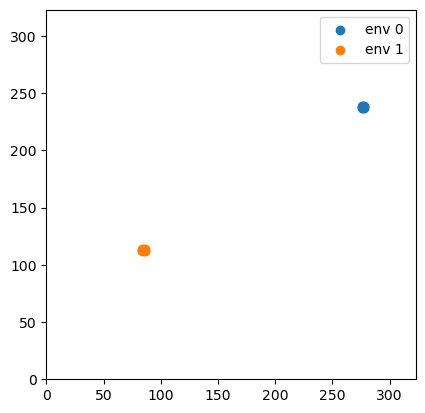

In [45]:
width, height = Npos, Npos

for env_idx in range(n_envs):
    env_indices = all_env_indices[env_idx]
    pos = env_indices.reshape(-1, 2)
    plt.scatter(pos[:, 0], pos[:, 1], label=f"env {env_idx}")

plt.xlim(0, width)
plt.ylim(0, height)
plt.gca().set_aspect('equal', adjustable='box')  # keep the aspect ratio square
plt.legend()
plt.show()

In [6]:
def train_hebbian(patterns):
    """
    patterns: array of shape (P, N), each in {0,1}
    Returns: weight matrix W with zero diagonal, using centered Hebbian rule.
    """
    P, N = patterns.shape
    # Center the patterns around 0.5 so that mean activity ~0
    centered = patterns - 0.5
    W = (centered.T @ centered) / N
    np.fill_diagonal(W, 0.0)
    return W

def recall(state, W, b, steps=10):
    s = state.astype(int).copy()
    for _ in range(steps):
        h = W @ s + b
        s = (h >= 0).astype(int)
    return s


def recall_async(state, W, b, steps=10, rng=None, track_energy=False):
    s = state.astype(int).copy()
    N = len(s)
    rng = np.random.default_rng() if rng is None else rng
    energies = [] if track_energy else None

    def energy(s):
        # Binary Hopfield energy (up to constant)
        return -0.5 * s @ W @ s - b @ s

    for _ in range(steps):
        order = rng.permutation(N)
        for i in order:
            h_i = W[i] @ s + b[i]
            s[i] = 1 if h_i >= 0 else 0
        if track_energy:
            energies.append(energy(s))

    if track_energy:
        return s, energies
    return s
    
def overlaps(x, y, px, py, size, touch_ok=True):
    if touch_ok:
        # touching edges allowed
        return not (x + size <= px or px + size <= x or y + size <= py or py + size <= y)
    else:
        # touching counts as overlap
        return not (x + size <  px or px + size <  x or y + size <  py or py + size <  y)

In [54]:
X = torch.from_numpy(gbook.reshape(len(gbook), -1))
X = torch.from_numpy(pbook[:, 0, :])
# normalize if you want cosine similarity
Xn = X / X.norm(dim=0, keepdim=True)
S = Xn.T @ Xn  # [n_samples, n_samples] similarity matrix

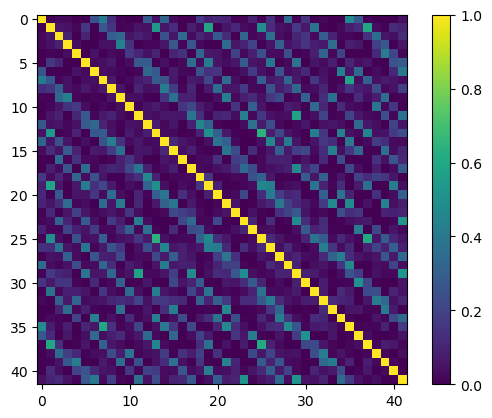

In [55]:
#set diagonal to 0
# S[np.arange(len(S)), np.arange(len(S))] = 0

plt.imshow(S)
plt.colorbar()
plt.show()

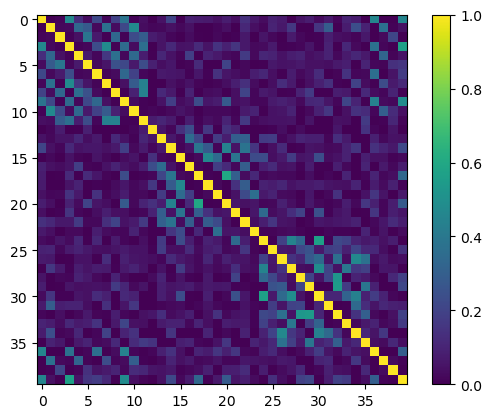

In [37]:
#set diagonal to 0
# S[np.arange(len(S)), np.arange(len(S))] = 0

plt.imshow(S[:40, :40])
plt.colorbar()
plt.show()


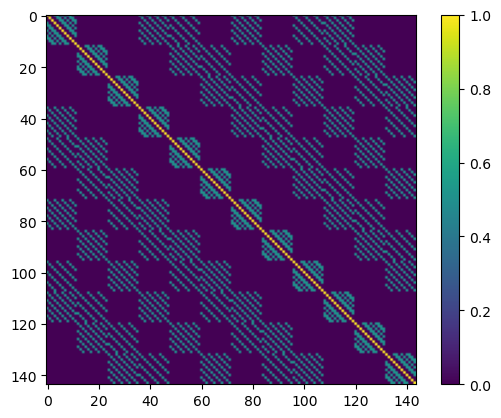

In [43]:
plt.imshow(S)
plt.colorbar()
plt.show()


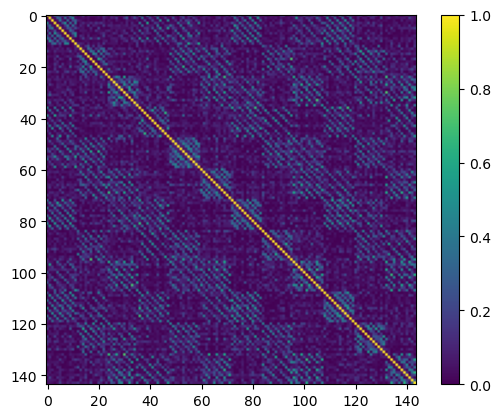

In [41]:
plt.imshow(S)
plt.colorbar()
plt.show()


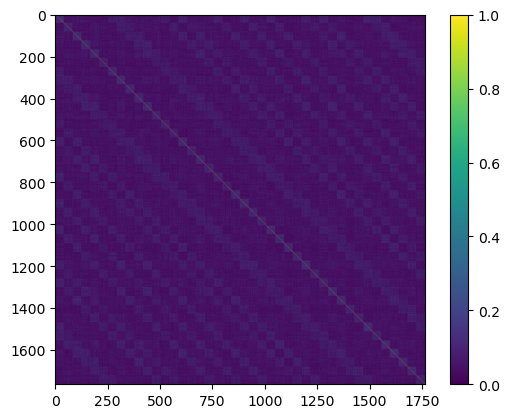

In [10]:
plt.imshow(S)
plt.colorbar()
plt.show()


In [47]:
book = pbook #gbook
def plot_results(target, other_target, g, recovered):
    # stack everything into a 4xN binary array
    data = np.vstack([g, recovered, target, other_target]).astype(float)
    n_rows, n_cols = data.shape

    # base grayscale image (white=0, black=1)
    img = np.repeat(data[:, :, None], 3, axis=2)  # RGB
    img = 1 - img  # make 1 -> black, 0 -> white for consistency with Greys cmap

    # determine color of the recall row (index 1)
    if np.array_equal(recovered, target):
        recall_color = np.array([0.0, 1.0, 0.0])  # green
    elif np.array_equal(recovered, other_target):
        recall_color = np.array([1.0, 0.0, 0.0])  # red
    else:
        recall_color = np.array([1.0, 0.5, 0.0])  # orange

    # apply color tint to the recall row (where bits are 1 / black)
    recall_mask = data[1] > 0.5
    img[1, recall_mask, :] = recall_color * 0.8  # colored cells (dim a bit)
    img[1, ~recall_mask, :] = 1.0  # white background for zeros

    # plot
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.imshow(img, aspect="auto", interpolation="none")

    ax.set_yticks(np.arange(n_rows))
    ax.set_yticklabels(["Input", "Recall", "Goal", "Other Goal"])
    ax.set_xticks([])

    # grid lines
    ax.set_xticks(np.arange(-0.5, n_cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, n_rows, 1), minor=True)
    ax.grid(which="minor", color="lightgray", linestyle="-", linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    plt.show()

In [58]:
for x in range(pbook.shape[1]):
    for y in range(pbook.shape[2]):
        if np.all(pbook[:, x, y] == recovered):
            print(x, y)


In [ ]:
import torch
import torch.nn.functional as F

def hopfield_lookup_torch(patterns, query, beta=1.0, l2_normalize=False, values=None):
    """
    patterns: [N, D]  (stored patterns = keys)
    query:    [D] or [B, D]
    values:   [N, P] optional; if None, uses patterns as values (P = D)
    beta:     temperature (higher = sharper lookup)
    l2_normalize: if True, cosine-style similarity

    returns:
      out:   [P] or [B, P]     (retrieved value)
      attn:  [N] or [B, N]     (attention over stored patterns)
    """
    if query.dim() == 1:
        query = query.unsqueeze(0)         # -> [1, D]

    if l2_normalize:
        patterns = F.normalize(patterns, dim=-1)
        query    = F.normalize(query,    dim=-1)

    # similarities: [B, N]
    sim = beta * (query @ patterns.T)

    # attention over stored patterns: [B, N]
    attn = sim.softmax(dim=-1)

    # use patterns as values if none provided
    V = patterns if values is None else values  # [N, P]
    out = attn @ V                              # [B, P]

    # squeeze back if input was unbatched
    if out.size(0) == 1:
        return out.squeeze(0), attn.squeeze(0)
    return out, attn


In [49]:
memories = np.stack(goal_states)
print(memories.shape)
W = train_hebbian(memories)
b = -W @ np.full(W.shape[0], 0.5)
    
for env_idx in range(n_envs):
    target = memories[env_idx]
    if n_envs > 1:
        other_target = memories[1-env_idx]
    env_indices = all_env_indices[env_idx]
    correct = 0

    for x in range(size):
        for y in range(size):
            location = env_indices[x, y]
            g = book[:, location[0], location[1]]
            # recovered, energies = recall_async(g, W, b, steps=20, track_energy=True)
            recovered, attn = hopfield_lookup_torch(torch.from_numpy(memories), torch.from_numpy(g), beta=1e6, l2_normalize=False)
            print(location)
            # if n_envs > 1:
            #     plot_results(target, other_target, g, recovered)
            
            recovered = np.array(recovered)

            # # --- Plot energies ---
            # fig, ax = plt.subplots(figsize=(5, 1))
            # plt.plot(energies)
            # plt.xlabel("Sweep")
            # plt.ylabel("Energy")
            # plt.title("Asynchronous Hopfield recall energy trajectory")
            # plt.show()

            if np.all(recovered == target):
                correct += 1

    print(f"Env {env_idx} accuracy: {correct} / {size**2}")

(2, 3600)
[80 86]
[80 87]
[80 88]
[80 89]
[80 90]
[81 86]
[81 87]
[81 88]
[81 89]
[81 90]
[82 86]
[82 87]
[82 88]
[82 89]
[82 90]
[83 86]
[83 87]
[83 88]
[83 89]
[83 90]
[84 86]
[84 87]
[84 88]
[84 89]
[84 90]
Env 0 accuracy: 14 / 25
[125  44]
[125  45]
[125  46]
[125  47]
[125  48]
[126  44]
[126  45]
[126  46]
[126  47]
[126  48]
[127  44]
[127  45]
[127  46]
[127  47]
[127  48]
[128  44]
[128  45]
[128  46]
[128  47]
[128  48]
[129  44]
[129  45]
[129  46]
[129  47]
[129  48]
Env 1 accuracy: 16 / 25


/tmp/ipykernel_309430/3060069857.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  recovered = np.array(recovered)
